In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = True

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, MultipleLocator
from matplotlib import patheffects as pe
import numpy as np
from copy import deepcopy
from cmcrameri import cm

import scipy.integrate as integ

In [2]:
# %matplotlib widget

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# constants
sbc = 5.67e-8   # stefan-boltzman constant
M_E = 6e24 # Rarth mass [kg]
day = 24.0*60*60 # length of day in seconds
year = 365.24 * day

In [4]:
class planet():

    def __init__(self):

        # parameters
        self.c_p = 1250.0     # heat capacity [J kg-1 K-1]
        self.rho = 4550.0    # density [kg m-3]
        self.S_0 = 24.7*1361.0    # instellation [W m-2]
        self.T_0 = 3500.0    # initial temperature [K]
        self.T_s = 1500.0    # solidus temperature [K]
        self.T_l = 2000.0    # liquidus temperature [K]
        self.alb = 0.3       # shortwave albedo
        self.ems = 0.7       # longwave emissivity
        self.M_p = 0.47 * M_E   # mass of planet [kg]
        self.F_c = 0.0       # internal heat flux [W m-2]

        # Derived quantities
        self.r2   = (3 * self.M_p / (4 * self.rho * np.pi))**(2.0/3.0) # radius squared
        self.T_cen = 0.5*(self.T_s + self.T_l)
        self.T_wid = 0.5*(self.T_l - self.T_s)

        # result
        self.sol_x = None
        self.sol_y = None

    # Calculate melt fraction from temperature
    def _phi(self, tmp):
        if tmp <= self.T_s:
            # fully solid
            return 0.0
        elif tmp >= self.T_l:
            # fully liquid
            return 1.0
        else:
            # mushy
            return (tmp - self.T_s)/(self.T_l-self.T_s)

    # Rate of change in temperature
    def _dTdt(self, Tt):
        # interior heating
        F_int = self.F_c * np.exp(-1.0 * ((Tt-self.T_cen)/self.T_wid)**2)
        out  = 0.0
        out += (1-self.alb)*self.S_0/4.0
        out += F_int
        out -= sbc * self.ems * Tt**4
        out *= 4 * np.pi * self.r2 / (self.M_p * self.c_p)
        return out

    # ODE to solve
    def _ode(self, t, y):
        return (self._dTdt(y[0]),)

    # Evolve system over time
    def solve(self, t_max, nsamps=1000, linspace=False):

        t_span = (0,t_max*year*1.01)
        if linspace:
            t_eval = np.append([0.1],np.linspace(day, t_max*year, nsamps))
        else:
            t_eval = np.append([0.1],np.logspace(np.log10(day), np.log10(t_max*year), nsamps))

        result = integ.solve_ivp(self._ode, t_span, (self.T_0,),
                                    first_step=day/10, t_eval=t_eval)

        self.sol_x = result.t / year
        self.sol_y = result.y[0]
        succ = result.success
        if not succ:
            print("Success:",succ)
            print("\t",result.message)

        return self.sol_x, self.sol_y



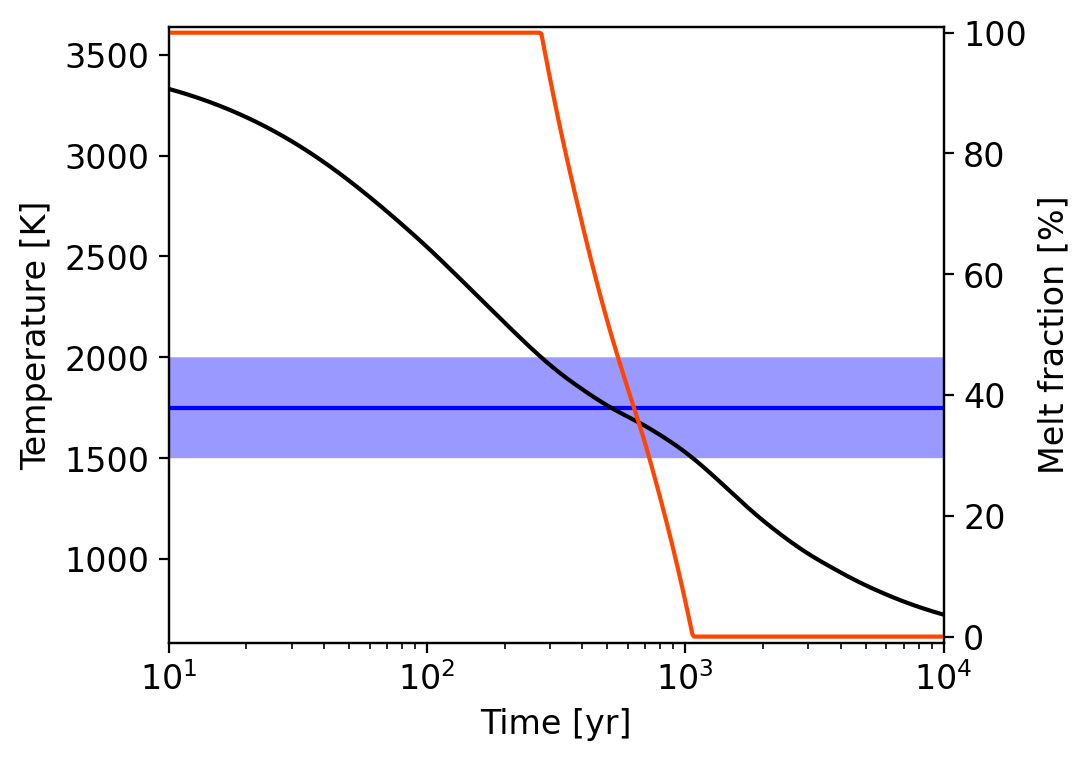

In [5]:
# single case

pl = planet()
pl.F_c = 5 * pl.S_0
sol_x, sol_y = pl.solve(1e4)
sol_d = [pl._dTdt(y)*year for y in sol_y]
sol_p = [pl._phi(y)*100 for y in sol_y]

fig, ax = plt.subplots(1,1, figsize=(5,4))
axr = ax.twinx()

ax.fill_between(sol_x, pl.T_cen+pl.T_wid, pl.T_cen-pl.T_wid, color='b', alpha=0.4, edgecolor=None)
ax.axhline(pl.T_cen, color='b')

ax.plot(sol_x, sol_y, color='k')

ax.set_xlabel("Time [yr]")
ax.set_ylabel("Temperature [K]")
ax.set_xscale("log")
ax.set_xlim(10, sol_x[-1])

axr.plot(sol_x, sol_p, color='orangered')
axr.set_ylabel("Melt fraction [%]")
axr.set_ylim(bottom=-1, top=101)

plt.show()


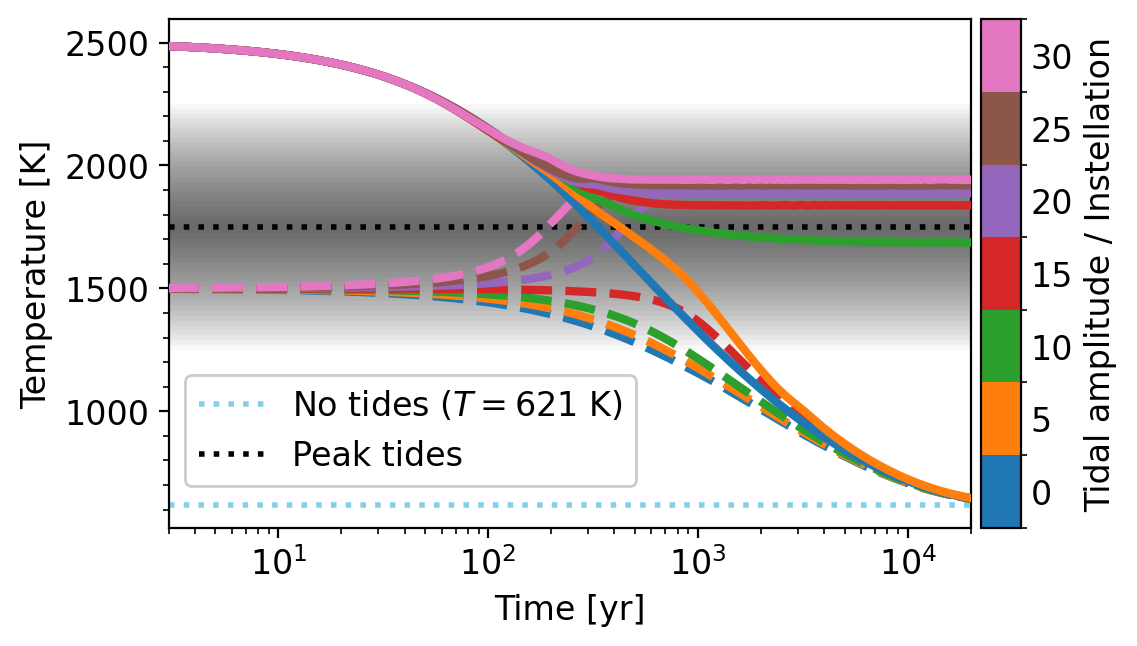

In [6]:
# multiple cases
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))

# null hypothesis
pl = planet()
sol_x, sol_y = pl.solve(t_max=1e7)
y_noh = float(sol_y[-1])
ax.axhline(y=y_noh, color='skyblue', linestyle='dotted', label=r"No tides ($T=%.0f$ K)"%y_noh, lw=2)

# mixed phase region
res = 25
for q in np.linspace(0.1, 2.0, res):
    ax.fill_between(sol_x, pl.T_cen+pl.T_wid*q, pl.T_cen-pl.T_wid*q, color='k', alpha=0.8/res, edgecolor=None, zorder=0)
ax.axhline(pl.T_cen, color='k', label="Peak tides", ls='dotted', lw=2, zorder=1)

dx = 5
x_arr = np.arange(0, 30.0+dx, dx)
lw = 3
cmap = "tab10"
norm = mpl.colors.BoundaryNorm(boundaries=np.append(x_arr, x_arr[-1]+dx)-dx/2, ncolors=len(x_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 1500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=2e4)
    ax.plot(sol_x, sol_y, color=sm.to_rgba(x), ls='dashed', zorder=3, lw=lw)#, path_effects=[pe.Stroke(linewidth=lw*1.8, foreground='w'), pe.Normal()])

for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=2e4)
    ax.plot(sol_x, sol_y, color=sm.to_rgba(x), zorder=4, lw=lw)#, path_effects=[pe.Stroke(linewidth=lw*1.8, foreground='w'), pe.Normal()])

mappable = sm # mappable for colorbar
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mappable, cax=cax, orientation='vertical', ticks=x_arr)
cbar.ax.tick_params(size=0)
cbar.set_label("Tidal amplitude / Instellation")

ax.set_xlabel("Time [yr]")
ax.set_xscale("log")
ax.set_xlim(left=3, right=sol_x[-1])
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.set_ylabel("Temperature [K]")
ax.legend(framealpha=1.0, loc='lower left', bbox_to_anchor=(0,0.05))

plt.show()
fig.savefig("output/sa_evolve.pdf", bbox_inches="tight")

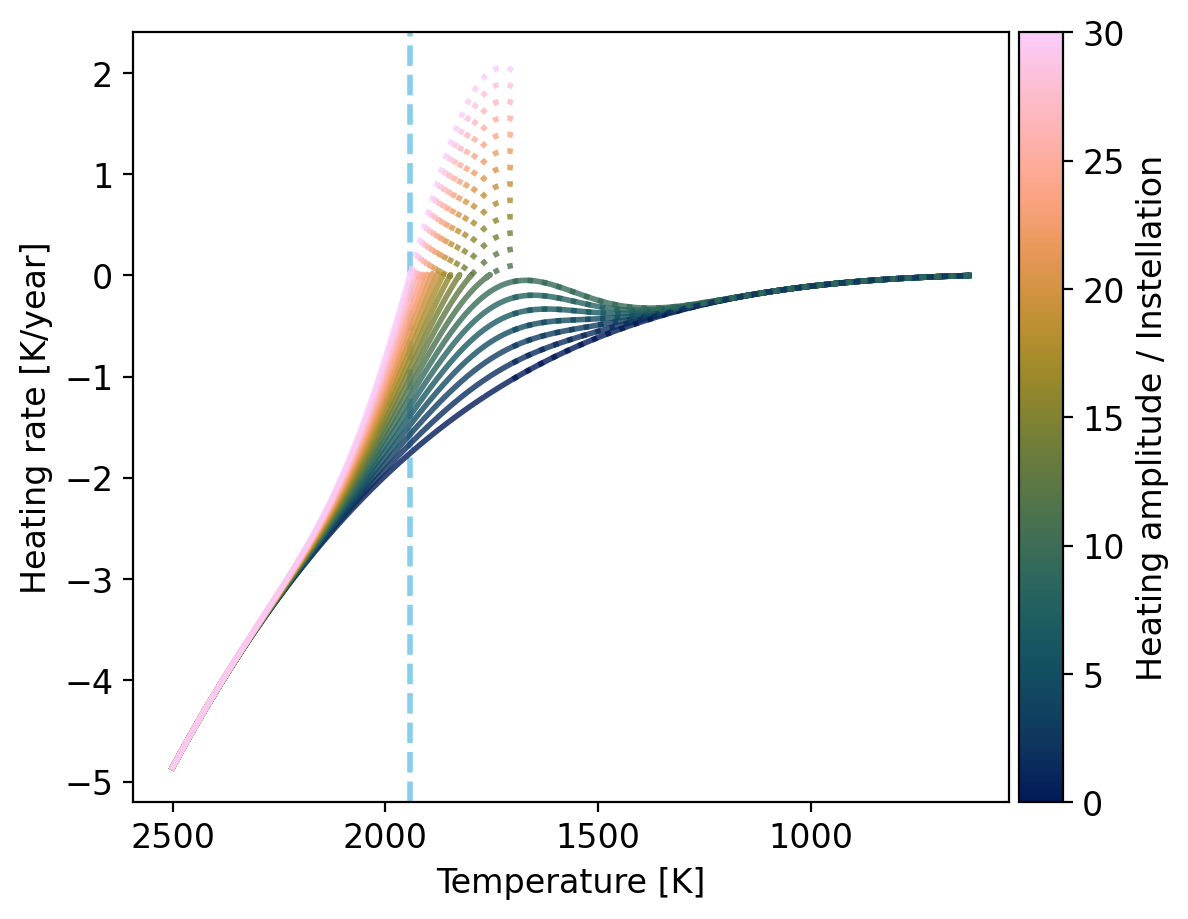

In [7]:
# multiple cases
fig, ax = plt.subplots(1,1, figsize=(6,5))

x_arr = np.linspace(0, 30.0, 20)

y_noh = float(sol_y[-1])
ax.axvline(x=y_noh, color='skyblue', linestyle='dashed', label=r"No tides ($T=%d$ K)"%y_noh, lw=2)


lw = 2
cmap = cm.batlow
norm = mpl.colors.Normalize(vmin=x_arr[0], vmax=x_arr[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=3e4)
    plt_x = sol_y[1:]
    plt_y = [pl._dTdt(Tt)*year for Tt in plt_x]
    ax.plot(plt_x, plt_y, color=sm.to_rgba(x), ls='solid', lw=lw, alpha=0.8)

for x in x_arr:
    pl = planet()
    pl.T_0 = 1700
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=3e4)
    plt_x = sol_y[1:]
    plt_y = [pl._dTdt(Tt)*year for Tt in plt_x]
    ax.plot(plt_x, plt_y, color=sm.to_rgba(x), ls='dotted', lw=lw, alpha=0.8)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label("Heating amplitude / Instellation")

ax.set_xlabel("Temperature [K]")
ax.invert_xaxis()
ax.set_ylabel("Heating rate [K/year]")

plt.show()

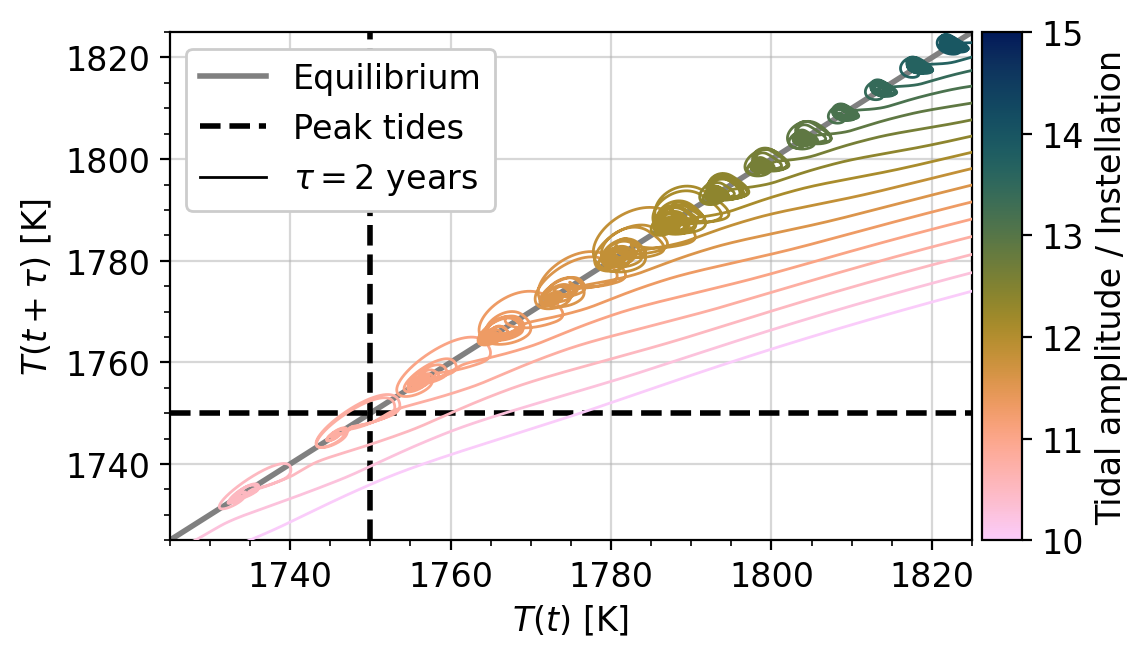

In [19]:
# multiple cases
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))

x_arr = np.linspace(10, 15.0, 20)

di = 100

cmap = cm.batlow_r
norm = mpl.colors.Normalize(vmin=x_arr[0], vmax=x_arr[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_c = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=2e4, nsamps=di*100, linspace=True)
    dt = float(sol_x[30]-sol_x[29])
    plt_c = plt_x

    plt_x = sol_y[1:-1*di]
    plt_y = sol_y[1+di:]

    # ax.scatter(plt_x, plt_y, c=plt_x, s=2, zorder=5, cmap=cmap, norm=norm)
    ax.plot(plt_x, plt_y, lw=1, zorder=5, color=sm.to_rgba(x))

ax.plot([0,pl.T_0],[0,pl.T_0], zorder=2, color='grey', lw=2, label="Equilibrium")
ax.axhline(pl.T_cen, color='k', label="Peak tides", ls='dashed', lw=2, zorder=3)
ax.axvline(pl.T_cen, color='k', ls='dashed', lw=2, zorder=3)

ax.plot(-1, -1, lw=1, zorder=5, color='k', label=r"$\tau = $%.g years"%dt)

ax.set_xlim(1725, 1825)
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.set_ylim(1725, 1825)
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label("Tidal amplitude / Instellation")

ax.set_xlabel(r"$T(t)$ [K]")
ax.set_ylabel(r"$T(t+\tau)$ [K]")
ax.grid(zorder=-3, alpha=0.5)
ax.legend(framealpha=1.0)

plt.show()
fig.savefig("output/sa_logistic.pdf", bbox_inches="tight")

In [9]:
x_arr = []
y_arr = []
z_arr = []

for x in np.linspace(1350, 1800, 40): # initial temperature
    for y in np.linspace(0, 30,  40): # heating maximum
        pl = planet()
        pl.T_0 = x
        pl.F_c = y * pl.S_0

        # solve
        sol_x, sol_y = pl.solve(t_max=1e4)

        # store
        x_arr.append(x)
        y_arr.append(y)
        z_arr.append(sol_y[-1])

KeyboardInterrupt: 

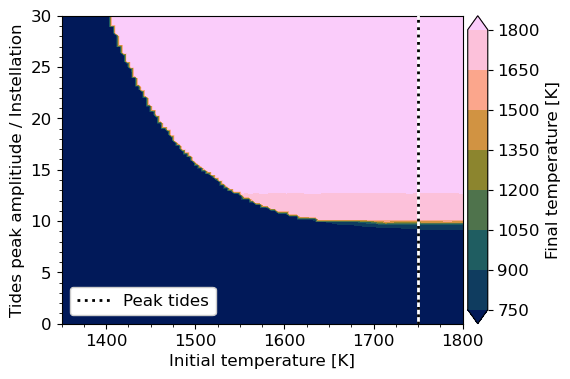

In [311]:
# multiple dimensions
fig, ax = plt.subplots(1,1, figsize=(5.5,4))

cmap = deepcopy(cm.batlow)
norm = mpl.colors.Normalize(vmin=np.percentile(z_arr,45), vmax=np.percentile(z_arr,55))
mp = ax.tricontourf(x_arr, y_arr, z_arr, cmap=cmap, norm=norm, levels=8, zorder=1, extend='both')

# mixed phase region
ax.axvline(pl.T_cen, color='w',ls='solid', lw=2, zorder=4)
ax.axvline(pl.T_cen, color='k', label="Peak tides", ls='dotted', lw=2, zorder=5)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mp, cax=cax, orientation='vertical')
cbar.set_label("Final temperature [K]")

ax.set_xlabel("Initial temperature [K]")
ax.set_xlim(left=x_arr[0], right=x_arr[-1])
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

ax.set_ylabel("Tides peak amplitiude / Instellation")
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(framealpha=1.0, loc='lower left')

plt.show()
fig.savefig("output/sa_contour.pdf", bbox_inches="tight")